In [1]:
import os
import numpy as np
import tensorflow as tf

/home/dof6/.local/lib/python2.7/site-packages/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 2, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)


In [2]:
def _parse_function(example_proto):
    features = {
        'eef_position': tf.FixedLenFeature([], tf.string),
        'eef_quaternion': tf.FixedLenFeature([], tf.string),
        'eef_euler': tf.FixedLenFeature([], tf.string),
        'cropped_color_image': tf.FixedLenFeature([], tf.string),
        'cropped_depth_image': tf.FixedLenFeature([], tf.string),
        'grasp_width': tf.FixedLenFeature([], tf.float32),
        'grasp_depth': tf.FixedLenFeature([], tf.float32),
        'grasp_quality': tf.FixedLenFeature([], tf.float32)
    }
    parsed_features = tf.parse_single_example(example_proto, features)
    
    gripper_position = tf.decode_raw((parsed_features['eef_position']), tf.float32)
    gripper_position = tf.reshape(gripper_position,[3])
    
    gripper_quaternion = tf.decode_raw((parsed_features['eef_quaternion']), tf.float32)
    gripper_quaternion = tf.reshape(gripper_quaternion,[4])
    
    gripper_euler = tf.decode_raw((parsed_features['eef_euler']), tf.float32)
    gripper_euler = tf.reshape(gripper_euler,[3])
    
    cropped_color_image = tf.decode_raw((parsed_features['cropped_color_image']), tf.float32)
    cropped_color_image = tf.reshape(cropped_color_image,[50, 50, 3])
    
    cropped_depth_image = tf.decode_raw((parsed_features['cropped_depth_image']), tf.float32)
    cropped_depth_image = tf.reshape(cropped_depth_image,[50, 50, 1])
    
    grasp_depth = parsed_features['grasp_depth']
    grasp_depth = tf.reshape(grasp_depth,[1])
    
    grasp_width = parsed_features['grasp_width']
    grasp_width = tf.reshape(grasp_width,[1])
    
    grasp_quality = parsed_features['grasp_quality']
    grasp_quality = tf.reshape(grasp_quality,[1])

    return gripper_position, gripper_quaternion, gripper_euler, cropped_color_image, cropped_depth_image, grasp_depth, grasp_width, grasp_quality

In [3]:
tf.reset_default_graph()

training_dataset = tf.data.TFRecordDataset('./grasp_data/t_shape/training.tfrecord')
training_dataset = training_dataset.map(_parse_function)

training_dataset = training_dataset.repeat()
training_dataset = training_dataset.batch(200)
training_dataset = training_dataset.shuffle(buffer_size=200)

training_iterator = training_dataset.make_initializable_iterator()
training_gripper_position, training_gripper_quaternion, training_gripper_euler, training_cropped_color_image, training_cropped_depth_image, training_grasp_depth, training_grasp_width, training_grasp_quality = training_iterator.get_next()

test_dataset = tf.data.TFRecordDataset('./grasp_data/t_shape/test.tfrecord')
test_dataset = test_dataset.map(_parse_function)

test_dataset = test_dataset.repeat()
test_dataset = test_dataset.batch(200)

test_iterator = test_dataset.make_initializable_iterator()
test_gripper_position, test_gripper_quaternion, test_gripper_euler, test_cropped_color_image, test_cropped_depth_image, test_grasp_depth, test_grasp_width, test_grasp_quality = test_iterator.get_next()

print('Training Iterator')
print(training_gripper_position.shape)
print(training_gripper_quaternion.shape)
print(training_cropped_color_image.shape)
print(training_cropped_depth_image.shape)
print(training_grasp_quality.shape)

print('Test Iterator')
print(test_gripper_position.shape)
print(test_gripper_quaternion.shape)
print(test_cropped_color_image.shape)
print(test_cropped_depth_image.shape)
print(test_grasp_quality.shape)

W0804 15:14:41.551829 140273787422464 deprecation.py:323] From <ipython-input-3-809223fd69ce>:10: make_initializable_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.


Training Iterator
(?, 3)
(?, 4)
(?, 50, 50, 3)
(?, 50, 50, 1)
(?, 1)
Test Iterator
(?, 3)
(?, 4)
(?, 50, 50, 3)
(?, 50, 50, 1)
(?, 1)


In [4]:
def quality_network_build(cropped_depth_image, gripper_quaternion, reuse=False, use_bn=True, network_type="large"):
    with tf.variable_scope("quality_network",reuse=reuse):
        if network_type is "large":
            h = tf.layers.conv2d(cropped_depth_image, 32, [7,7], activation=tf.nn.relu,
                                 kernel_initializer=tf.random_normal_initializer(stddev=0.01), name="conv1")
            if use_bn:
                h = tf.layers.batch_normalization(h)
            h = tf.layers.conv2d(h, 32, [7,7], activation=tf.nn.relu,
                                 kernel_initializer=tf.random_normal_initializer(stddev=0.01), name="conv2")
            if use_bn:
                h = tf.layers.batch_normalization(h)
            h = tf.layers.max_pooling2d(h, [2,2], [2,2], name="max1")
            h = tf.layers.conv2d(h, 32, [5,5], activation=tf.nn.relu,
                                 kernel_initializer=tf.random_normal_initializer(stddev=0.01), name="conv3")
            if use_bn:
                h = tf.layers.batch_normalization(h)
            h = tf.layers.conv2d(h, 32, [5,5], activation=tf.nn.relu,
                                 kernel_initializer=tf.random_normal_initializer(stddev=0.01), name="conv4")
            if use_bn:
                h = tf.layers.batch_normalization(h)
            h = tf.layers.max_pooling2d(h, [3,3], [2,2], name="max2")
            h = tf.layers.conv2d(h, 128, [5,5], activation=tf.nn.relu,
                                 kernel_initializer=tf.random_normal_initializer(stddev=0.01), name="conv5")
            if use_bn:
                h = tf.layers.batch_normalization(h)
            h = tf.reshape(h,[-1,128])
            h = tf.concat([h, gripper_quaternion], axis=1)
            h = tf.layers.dense(h, 256, activation=tf.nn.relu,
                                kernel_initializer=tf.random_normal_initializer(stddev=0.01), name="fc1")
            h = tf.layers.dense(h, 256, activation=tf.nn.relu,
                                kernel_initializer=tf.random_normal_initializer(stddev=0.01), name="fc2")
               
        quality_logit = tf.layers.dense(h, 1,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01), name="quality_logit")
        quality = tf.sigmoid(quality_logit)
    return quality_logit, quality

_, training_quality_prediction = quality_network_build(training_cropped_depth_image,training_gripper_quaternion)
_, test_quality_prediction = quality_network_build(test_cropped_depth_image,test_gripper_quaternion, reuse=True)

W0804 15:14:41.645776 140273787422464 deprecation.py:323] From <ipython-input-4-c099770e3210>:5: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W0804 15:14:41.872872 140273787422464 deprecation.py:323] From <ipython-input-4-c099770e3210>:7: batch_normalization (from tensorflow.python.layers.normalization) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
W0804 15:14:41.970994 140273787422464 deprecation.py:323] From <ipython-input-4-c099770e3210>:12: max_pooling2d (from tensorflow.python.layers.pooling) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
W0804 15:14:42

In [5]:
training_loss = -training_grasp_quality*tf.log(training_quality_prediction+1e-8) - (1.-training_grasp_quality)*tf.log((1.-training_quality_prediction)+1e-8)
training_loss = tf.reduce_mean(training_loss)
equality = tf.equal(tf.cast(training_quality_prediction > 0.5, tf.float32), training_grasp_quality)
training_accuracy = tf.reduce_mean(tf.cast(equality, tf.float32))

test_loss = -test_grasp_quality*tf.log(test_quality_prediction+1e-8) - (1.-test_grasp_quality)*tf.log((1.-test_quality_prediction)+1e-8)
test_loss = tf.reduce_mean(test_loss)
equality = tf.equal(tf.cast(test_quality_prediction > 0.5, tf.float32), test_grasp_quality)
test_accuracy = tf.reduce_mean(tf.cast(equality, tf.float32))

print(training_loss.shape)
print(test_loss.shape)

()
()


In [6]:
def optimizer(training_loss, initial_learning_rate=1e-4, decay_type=None, max_steps=1500):
    if decay_type is None:
        learning_rate = initial_learning_rate
    elif decay_type is "cosine_decay":
        global_step = tf.train.get_or_create_global_step()
        learning_rate = tf.train.cosine_decay(initial_learning_rate, global_step, max_steps)
    elif decay_type is "linear_cosine_decay":
        global_step = tf.train.get_or_create_global_step()
        learning_rate = tf.train.linear_cosine_decay(initial_learning_rate, global_step, max_steps)

    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_loss_optimizer = optimizer.minimize(training_loss)
    return training_loss_optimizer

training_loss_optimizer = optimizer(training_loss, initial_learning_rate=1e-4)

In [7]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
sess.run(training_iterator.initializer)
sess.run(test_iterator.initializer)
sess.run(tf.global_variables_initializer())

In [9]:
from collections import deque
import numpy as np

epoches = 250
training_loss_list = []
training_acc_list = []
test_acc_list = []
training_batch = 500
test_batch = 100

for epoch in range(epoches):
    avg_training_loss = 0
    avg_training_acc = 0
    
    for i in range(training_batch):
        training_loss_np, training_accuracy_np, _ = sess.run([training_loss, training_accuracy, training_loss_optimizer])
        avg_training_loss += training_loss_np/training_batch
        avg_training_acc += training_accuracy_np/training_batch
        
    avg_test_acc = 0
    for _ in range(test_batch):
        test_accuracy_np, = sess.run([test_accuracy])
        avg_test_acc += test_accuracy_np/test_batch
    
    print(avg_training_loss, avg_training_acc, avg_test_acc)
    training_loss_list.append(avg_training_loss)
    training_acc_list.append(avg_training_acc)
    test_acc_list.append(avg_test_acc)

(0.20855696417391334, 0.9070299992561338, 0.893499999642372)
(0.20571058008447268, 0.9104800004959103, 0.8963999974727633)
(0.20773050656169648, 0.9073799995183934, 0.902499998807907)
(0.20126358603313563, 0.912019999027253, 0.8923999983072285)
(0.20854194402322188, 0.9080200011730191, 0.8920000004768374)
(0.1999400777369737, 0.9133500018119803, 0.9014499962329866)
(0.20372863617539425, 0.9106400002241143, 0.8918499982357028)
(0.20138106142357012, 0.9126000001430513, 0.8969499987363816)
(0.19648613476566967, 0.9120100001096726, 0.903999999165535)
(0.19856600737571725, 0.9129600014686582, 0.8980999976396564)
(0.20448127267509716, 0.9087700010538093, 0.8934500008821487)
(0.19560368781397125, 0.9148100000619885, 0.905649998188019)
(0.1975602662879975, 0.912380000591278, 0.898550002574921)
(0.20071421094611272, 0.9114000002145757, 0.8967000025510787)
(0.1929586885191966, 0.9164499989748006, 0.9035000008344647)
(0.18866380009055153, 0.9173000005483629, 0.8957999980449677)
(0.197175679687410

In [1]:
saver = tf.train.Saver()
saver.save(sess,'./grasp_quality_model/grasp_quaternion_quality_network.ckpt')

NameError: name 'tf' is not defined

In [13]:
from matplotlib import pyplot as plt
%matplotlib inline

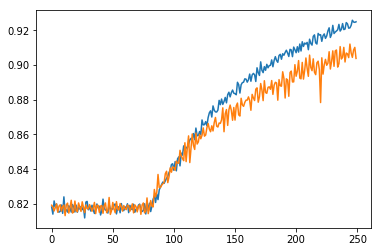

In [14]:
plt.plot(training_acc_list)
plt.plot(test_acc_list)
plt.show()